# Time Series Analysis

## Introduction
The essential difference between modeling data via time series methods and classic machine learning methods is the following:
Time series analysis accounts for the fact that data points taken over time may have an internal structure (such as autocorrelation, trend or seasonal variation) that should be accounted for.
This lecture will give a brief overview of some of the more widely used techniques in the rich and rapidly growing field of time series modeling and analysis. The next lecture will give applied examples using the facebook prophet library for time series analysis.

*Definition of Time Series:* An ordered sequence of values of a variable at equally spaced time intervals.

*Applications:* The usage of time series models is twofold:
* Obtain an understanding of the underlying forces and structure that produced the observed data
* Fit a model and proceed to forecasting, monitoring or even feedback and feedforward control.

Time Series Analysis is used for many applications such as:
* Economic Forecasting
* Sales Forecasting
* Budgetary Analysis
* Stock Market Analysis
* Yield Projections
* Process and Quality Control
* Inventory Studies
* Workload Projections
* Utility Studies
* Census Analysis
* and many, many more...

There are many methods used to model and forecast time series

*Techniques:* The fitting of time series models can be an ambitious undertaking. There are many methods of model fitting including the following:
* Box-Jenkins ARIMA models
* Box-Jenkins Multivariate Models
* Holt-Winters Exponential Smoothing (single, double, triple)

## Smooting techniques

Inherent in the collection of data taken over time is some form of random variation. There exist methods for reducing or canceling the effect due to random variation. An often-used technique is "smoothing". This technique, when properly applied, reveals more clearly the underlying trend, seasonal and cyclic components.

### Averaging

In order to be able to predict the evolution of a metric over time, it is possible to use averaging techniques, that consists in predicting future values or estimating the general trend of the series using some sort of average of the measured values.
For example let's consider the following dataset :


In [1]:
# !pip install -q yfinance
import yfinance as yf  
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
# pio.templates.default = "jedha"
# pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Get the data of the stock AAPL
data = yf.download('NVDA','2019-01-01','2020-01-01')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,32.660000,34.619999,32.512501,34.055000,33.788891,50875200
2019-01-03,33.447498,33.790001,31.922501,31.997499,31.747469,70555200
2019-01-04,32.735001,34.432499,32.424999,34.047501,33.781456,58562000
2019-01-07,34.625000,36.222500,34.107498,35.849998,35.569859,70916000
2019-01-08,36.672501,36.695000,34.224998,34.957500,34.684349,78601600
...,...,...,...,...,...,...
2019-12-24,59.549999,59.827499,59.205002,59.654999,59.420006,13886400
2019-12-26,59.689999,60.080002,59.500000,59.797501,59.561943,18285200
2019-12-27,59.950001,60.084999,58.952499,59.217499,58.984238,25464400


Let's create a new column that contains the average level of the variable ```open``` and plot it in these two columns in the same graph, as well as calculate the MSE between both columns.

In [3]:
data["open_mean"] = data["Open"].mean()

fig = px.line(x=data.index, y=data["Open"])
fig.add_trace(px.line(x=data.index, y=data["open_mean"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

MSE = np.mean((data["Open"]-data["open_mean"])**2)
print("The MSE for this global average smoothing is : \n {}".format(MSE))

The MSE for this global average smoothing is : 
 38.68121712248775


Of course the global average smoothing is a rather naive smoothing technique for estimating a time Series characteristics or make forcasts for future values. In the present case, where the data shows a positive growth trend, the further away from the middle of the period we look, the higher the errors commited by this smoothing method.

### Single moving average

An alternative way to summarize the past data is to compute the mean of successive smaller sets of numbers of past data as follows :

$$
M_t = \frac{X_t+X_{t-1}+ ... +X_{t-T+1}}{T}
$$
Where $t$represents the observed date, $X_t$ is the value of the observed time series at date $t$, and $T$ is the number of dates observed by the moving average (aslo called the order of the moving average).

Let's now compute the moving average of order 7 (duration of a week) moving average on the ```Open``` column of our dataset.


In [4]:
y = data["Open"]
MA7 = y.rolling(window=7)
data["Open_MA_7"] = MA7.mean()


# y a un effet de retard
# on peu pas calculer les 6 premières valeurs
fig = px.line(x=data.index, y=data["Open"])
fig.add_trace(px.line(x=data.index, y=data["Open_MA_7"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

As you can see, moving averages are much better at following the general trend of the data depending on the order selected (you can try different orders and witness the consequences on the visualization). However moving averages present a major drawback :
Since the moving average is calculated over the $T$ previous dates (current date included) it is always lagged compared to the actual time series, and the higher the order the longer the lag.

### Exponential Smoothing

This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, Exponential Smoothing assigns exponentially decreasing weights as the observation get older.

In other words, recent observations are given relatively more weight in forecasting than the older observations.

#### Single exponential smoothing

This smoothing scheme begins by setting $S_2$ to $X_1$, where $S_i$ stands for smoothed observation at date $i$.

For any date $t$, the smoothed value $S_t$ is given by :

$$
S_t = \alpha X_t + (1-\alpha)S_{t-1}
$$

Where $\alpha \in [0,1]$ and $t \geq 3$

Let's compute an exponential moving average for or column ```Open``` with $\alpha=0.1$ :

In [5]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

SES = SimpleExpSmoothing(data["Open"])
SES_fit = SES.fit(0.1)
SES_predict = SES_fit.predict(start=0, end = len(data)+30)

fig = px.line(x=range(len(data)), y=data["Open"])
fig.add_trace(px.line(x=SES_predict.index, y=SES_predict).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning:

Model has no free parameters to estimate. Set optimized=False to suppress this warning

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



What we see here is that exponential smoothing is able to smooth out the time series really well, however it presents two major flaws :
1. the smoothed series is lagged compared to the original series
2. when trying to predict future values as we did here, the series flatlines

#### Double exponential smoothing

As was previously observed, Single Smoothing does not excel in following the data when there is a trend. This situation can be improved by the introduction of a second equation with a second constant, $\gamma$, which must be chosen in conjunction with $\alpha$.

Here are the two equations associated with Double Exponential Smoothing:

$$
S_t = \alpha X_t + (1-\alpha)(S_{t-1} + b_{t-1}) \; \alpha \in [0,1]
$$

$$
b_t = \gamma(S_t - S_{t-1}) + (1-\gamma)b_{t-1} \; \gamma \in [0,1]
$$
Note that the current value of the series is used to calculate its smoothed value replacement in double exponential smoothing.
Let's calculate double exponential smoothing for our ```Open``` series.

In [8]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
DES = ExponentialSmoothing(data["Open"], trend = 'add')
# DES_fit = DES.fit()
DES_fit = DES.fit(.1, .9)
DES_predict = DES_fit.predict(start=0, end = len(data)+30)

fig = px.line(x=range(len(data)), y=data["Open"])
fig.add_trace(px.line(x=DES_predict.index, y=DES_predict).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



What strikes us here is the fact that the lag has greatly been reduced (even though still present) and future predictions now represent a positive trend similarly to our time series ! However, our predictions do not yet show the variations that are expected when looking at the data.

#### Triple exponential smoothing 

What happens if the data show trend and seasonality?

In this case double smoothing will not work. We now introduce a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.
The basic equations for their method are given by:

$$
S_t = \alpha \frac{X_t}{I_{t-T}} + (1-\alpha)(S_{t-1} + b_{t-1}) \textrm{  OVERALL SMOOTHING}
$$

$$
b_t = \gamma(S_t - S_{t-1}) + (1-\gamma)b_{t-1} \textrm{  TREND SMOOTHING}
$$

$$
I_t = \beta \frac{X_t}{S_t} + (1-\beta)I_{t-T} \textrm{  SEASONAL SMOOTHING}
$$

$$
F_{t+m} = (S_t + m b_t)I_{t-T+m} \textrm{  FORECAST}
$$

Where :
* $X$ is the observation
* $S$ is the smoothed observation
* $b$ is the trend factor
* $I$ is the seasonal index
* $F$ is the forecast at $m$ dates ahead
* $t$ is the data
* $T$ is the period of the potential seasonality

Let's now try and predict our time series using triple exponential smoothing also known as Holt Winters model :



In [12]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
TES = ExponentialSmoothing(data["Open"], trend = 'add', seasonal = 'add', seasonal_periods = 93)
# TES_fit = TES.fit(0.1, 0.1, 0.01)
TES_fit = TES.fit()
TES_predict = TES_fit.predict(start=0, end = len(data)+60)

fig = px.line(x=range(len(data)), y=data["Open"])
fig.add_trace(px.line(x=TES_predict.index, y=TES_predict).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig.show()

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\phili\anaconda3\envs\jedha\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



A slight lag is still present, but this time our forecasts have the advantage of presenting a trend and a seasonality that makes it able to infer believable predictions for the first few dates. After a while however, we notice that the predictions seem to have a very repetitive behavior and this means that the Holt Winters model is not a good candidate for long term predictions over time series (by long term understand further into the future than one seasonality period).

## Univariate time series modeling 

The term "univariate time series" refers to a single variable measured over time.

### Stationarity	
A common assumption in many time series techniques is that the data are stationary.

A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality).

Here's an example of a stationary time series :

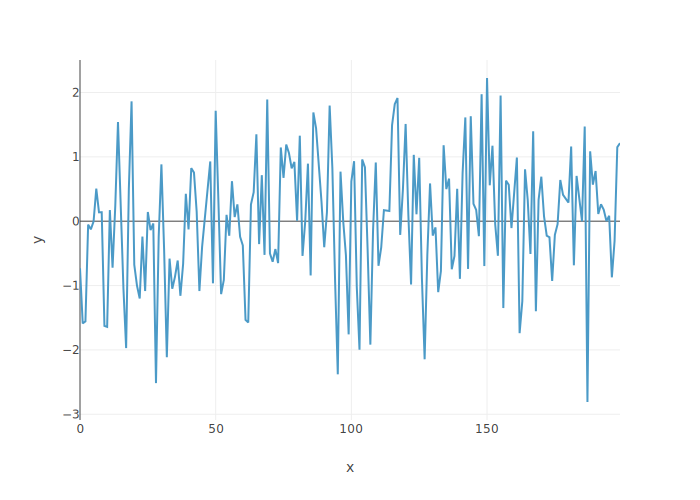

In [8]:
sample = np.random.randn(200)
px.line(x=range(200),y=sample)

### Transformations to Achieve Stationarity
If the time series is not stationary, we can often transform it to stationarity with one of the following techniques : 
* We can difference the data. That is, given the series $X_t$, we create the new series
$X'_t=X_t−X_{t−1}$.
The differenced data will contain one less point than the original data. Although you can difference the data more than once, one difference is usually sufficient.

* If the data contain a trend, we can fit some type of curve to the data and then model the residuals from that fit. Since the purpose of the fit is to simply remove long term trend, a simple fit, such as a straight line, is typically used.

* For non-constant variance, taking the logarithm or square root of the series may stabilize the variance. For negative data, you can add a suitable constant to make all the data positive before applying the transformation. This constant can then be subtracted from the model to obtain predicted (i.e., the fitted) values and forecasts for future points.

The above techniques are intended to generate series with constant location and scale. Although seasonality also violates stationarity, this is usually explicitly incorporated into the time series model.

### White noise

A discrete-time stochastic process $A_t$ is a discrete-time stochastic process which mean does not depend on the time $t$ and is equal to zero, i.e. $E[A_t]=0$ and if the autocorrelation function $E[A_t A_{t+k}]$ only depends on $k$ but not on $t$ and has a nonzero value only for $k=0$.
An example of white noise is displayed right before this section by forming a time series from random samples taken from a $N(0,1)$ normal distribution.

### Autoregressive (AR) Models

A common approach for modeling univariate time series is the autoregressive (AR) model:

$$
X_t = \delta + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_{p}X_{t-p} + A_t
$$

where $X_t$ is the time series, $A_t$ is white noise, and
$\delta=(1−\sum_{i=1}^{p}\phi_i)\mu$,
with $\mu$ denoting the process mean.

An autoregressive model is simply a linear regression of the current value of the series against one or more prior values of the series. The value of $p$ is called the order of the AR model.

AR models can be analyzed with one of various methods, including standard linear least squares techniques. They also have a straightforward interpretation.

### Moving Average Models

Another common approach for modeling univariate time series models is the moving average (MA) model:

$$
X_t = \mu + A_t - \theta_1 A_{t-1} -\theta_2 A_{t-2} - ... - \theta_q A_{t-q}
$$

where $X_t$ is the time series, $\mu$ is the mean of the series, $A_{t−i}$ are white noise terms, and $\theta_1,…,\theta_q$ are the parameters of the model. The value of $q$ is called the order of the MA model.

That is, a moving average model is conceptually a linear regression of the current value of the series against the white noise or random shocks of one or more prior values of the series. The random shocks at each point are assumed to come from the same distribution, typically a normal distribution, with location at zero and constant scale. The distinction in this model is that these random shocks are propogated to future values of the time series.

### Box-Jenkins ARIMA
The Box-Jenkins ARIMA model is a combination of the AR and MA models :

$$
D_t = \delta + \phi_1 X_{t-1} + \phi_2 X_{t-2} + ... + \phi_{p}X_{t-p} + A_t - \theta_1 A_{t-1} -\theta_2 A_{t-2} - ... - \theta_q A_{t-q}
$$

where the terms in the equation have the same meaning as given for the AR and MA model, and $D_t$ is a potentially differentiated version of the original time series $X_t$.

The I in ARIMA stands for integration, the model takes into account the level of integration it needs to go from $D_t$ back to $X_t$. Remember that AR and MA models can only work well on stationary time series (let alone seasonality), so $X_t$ may have to be differiated in order to achieve stationarity.

### Box-Jenkins Model Identification

#### Stationarity and Seasonality	
The first step in developing a Box-Jenkins model is to determine if the series is stationary and if there is any significant seasonality that needs to be modeled.

#### Detecting stationarity	
Stationarity can be assessed from a run sequence plot. The run sequence plot should show constant location and scale. It can also be detected from an autocorrelation plot. Specifically, non-stationarity is often indicated by an autocorrelation plot with very slow decay.

#### Detecting seasonality	
Seasonality (or periodicity) can usually be assessed from an autocorrelation plot, a seasonal subseries plot, or a spectral plot.

#### Differencing to achieve stationarity	
Box and Jenkins recommend the differencing approach to achieve stationarity. However, fitting a curve and subtracting the fitted values from the original data can also be used in the context of Box-Jenkins models.

#### Seasonal differencing	
At the model identification stage, our goal is to detect seasonality, if it exists, and to identify the order for the seasonal autoregressive and seasonal moving average terms. For many series, the period is known and a single seasonality term is sufficient. For example, for monthly data we would typically include either a seasonal AR 12 term or a seasonal MA 12 term. For Box-Jenkins models, we do not explicitly remove seasonality before fitting the model. Instead, we include the order of the seasonal terms in the model specification to the ARIMA estimation software. However, it may be helpful to apply a seasonal difference to the data and regenerate the autocorrelation and partial autocorrelation plots. This may help in the model idenfitication of the non-seasonal component of the model. In some cases, the seasonal differencing may remove most or all of the seasonality effect.

#### Identify p and q	
Once stationarity and seasonality have been addressed, the next step is to identify the order (i.e., the p and q) of the autoregressive and moving average terms.

| SHAPE |	INDICATED MODEL |
| --- | --- |
|Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model. |
|- |- |
| Alternating positive and negative, decaying to zero	| Autoregressive model. Use the partial autocorrelation plot to help identify the order. |
|- |- |
| One or more spikes, rest are essentially zero	| Moving average model, order identified by where plot becomes zero. |
|- |- |
| Decay, starting after a few lags |	Mixed autoregressive and moving average model.|
|-|-|
|All zero or close to zero |	Data is essentially random.|
|- |- |
| High values at fixed intervals 	| Include seasonal autoregressive term.|
|- |- |
| No decay to zero	| Series is not stationary.|

#### Autocorrelation

Autocorrelation is a measure of the correlation of the time series with itself given a certain lag, for example the autocorrelation of a series $X$ of order $p$ is the value:

$$
\rho_p = \frac{E[(X_t - \bar{X})(X_{t-p}-\bar{X})]}{\sigma^2}
$$
Where $\sigma^2$ is the variance of the series, and $\bar{X}$ is the mean of the series (generally = 0 because we are working with stationary series).

Let's take a look at the autocorrelation graph for our ```Open``` series.


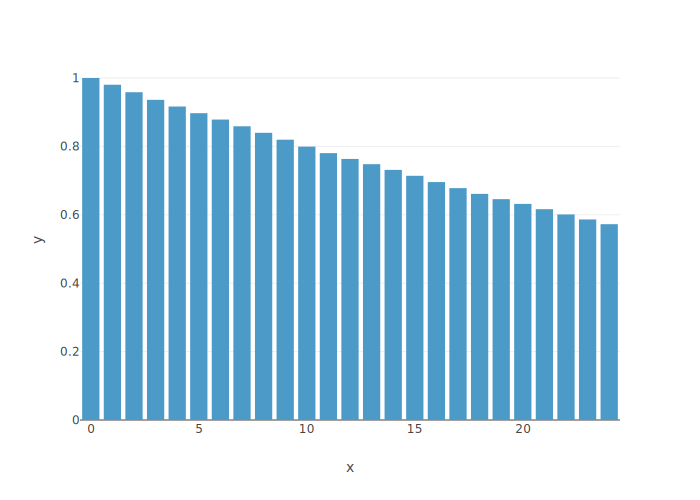

In [9]:
'''autocorrelation'''
import statsmodels.api as sm
Open = data["Open"]

autocor = pd.Series(sm.tsa.stattools.acf(Open))

fig = px.bar(x = autocor.index, y = autocor)
fig.show()

The autocorrelation graph does not indicate stationarity because we have not removed the trend from the data. We could do this by differentiating the series once.

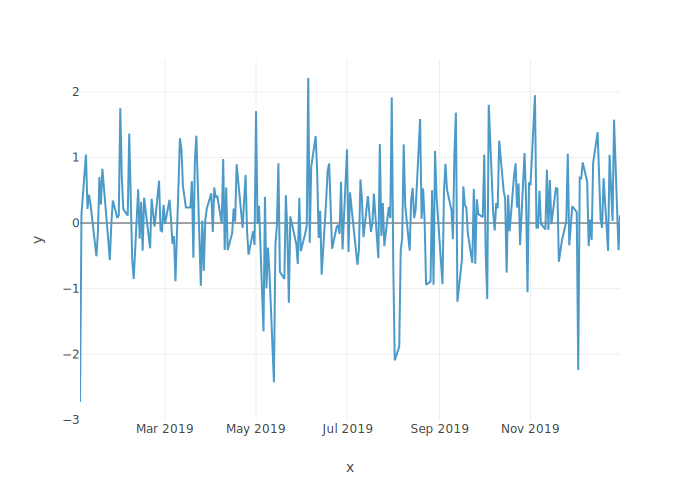

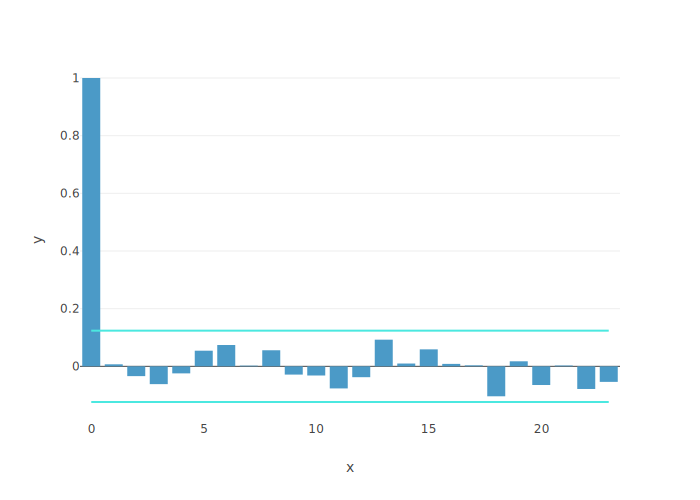

In [10]:
Open_diff = Open.diff()[1:]
autocor = pd.Series(sm.tsa.stattools.acf(Open_diff))

fig = px.line(x= Open_diff.index, y= Open_diff)
fig.show()

fig = px.bar(x = autocor.index, y = autocor)
fig.add_trace(px.line(x = autocor.index, y = [1.96/np.sqrt(len(Open_diff)) for i in autocor.index]).data[0])
fig.add_trace(px.line(x = autocor.index, y = [-1.96/np.sqrt(len(Open_diff)) for i in autocor.index]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig['data'][2]['line']['color']="#4BE8E0"
fig.show()

Here, no autocorrelation level is significant at 95% (the significance level is indicated byt the red lines) So the data might be randomly distributed.

#### Partial autocorrelations
The issue when measuring autocorrelations is that the autocorrelation measured at order 3 also contains indirect correlation of order 2 and 1. Indeed if $X_t$ and $X_{t-1}$ are autocorrelated, then $X_{t-3}$ is correlated with $X_{t-2}$ and itself correlated to $X_{t-1}$, then $X_t$. Partial autocorrelation aims at representing the strict autocorrelation between $X_t$ and $X_{t-p}$ independently from lower autocorrelations order. The partial autocorrelation of oder $q$ is noted : $\alpha_q$

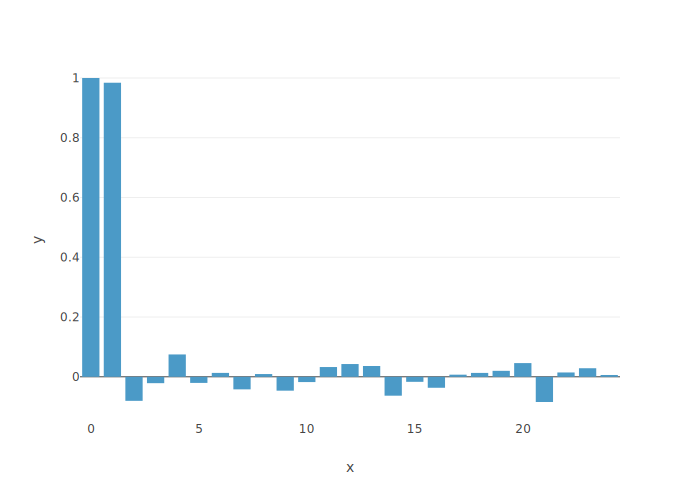

In [11]:
'''autocorrelation'''
import statsmodels.api as sm
Open = data["Open"]

pautocor = pd.Series(sm.tsa.stattools.pacf(Open))

fig = px.bar(x = pautocor.index, y = pautocor)
fig.show()

This is the partial autocorrelation graph for the undifferentiated data, however it is not stationnary so let's plot the partial autocorrelation graph for the differentiated series :

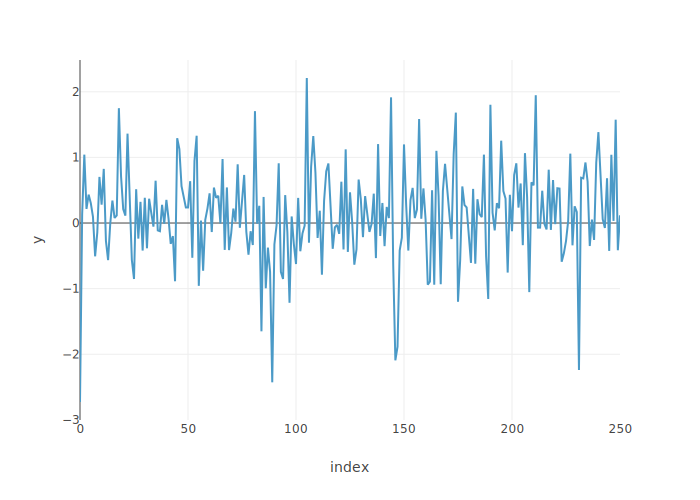

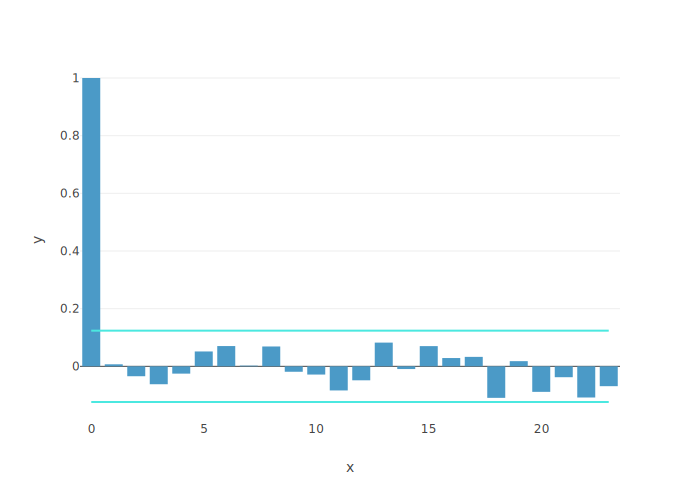

In [12]:
Open_diff = Open.diff()[1:]
pautocor = pd.Series(sm.tsa.stattools.pacf(Open_diff))

fig = px.line(Open_diff.index, y= Open_diff)
fig.show()

fig = px.bar(x = pautocor.index, y = pautocor)
fig.add_trace(px.line(x = pautocor.index, y = [1.96/np.sqrt(len(Open_diff)) for i in pautocor.index]).data[0])
fig.add_trace(px.line(x = pautocor.index, y = [-1.96/np.sqrt(len(Open_diff)) for i in pautocor.index]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig['data'][2]['line']['color']="#4BE8E0"
fig.show()

The conclusion here is that data appears to be randomly distributed over time, which is not entirely surprising for stocks.

## Conclusion

You now know about most standard analysis tools for univariate time series. For a practical approach to time series modeling, move on to the next lecture "Time series with Prophet" that will teach you how to build a time series model very easily with facebook prophet.